In [15]:
import torch

import numpy as np

import matplotlib.pyplot as plt

from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import ipywidgets as widgets
from ipywidgets import interact

In [16]:
from ode import ODEnetSimple
from utils import ConvAE

In [17]:
pathOde = "models/AE_ODE/centered_spiral_encoded_0_6_final_data_mid_dim_100_v2.pt"
pathAE = "models/AE/conv_custom_2_gaussian_r_1_custom_loss_alpha_0_0.pt"
pathLatentPos = "images/AE_ODE/encoded_reconstruction/centered_encoded_samples_fast_spiral_2.npy"
pathInputs = "images/AE_ODE/encoded_reconstruction/centered_trues_images_fast_spiral_2.npy"


In [18]:
ode = ODEnetSimple(out_dim=2)
print(ode.load_state_dict(torch.load(pathOde)))

ae = ConvAE(height=28, width=28, latent_dim=2)
print(ae.load_state_dict(torch.load(pathAE)))

Number of parameters: 10602
<All keys matched successfully>
Number of parameters in the model: 220387
<All keys matched successfully>


In [19]:
latent_encoded = torch.from_numpy(np.load(pathLatentPos))
print(latent_encoded.shape)
inputs = torch.from_numpy(np.load(pathInputs)).float()
print(inputs.shape)
latent_encoded_computed = ae.encoder_linear(ae.encoder(inputs))
print(latent_encoded_computed.shape)


torch.Size([10000, 2])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 2])


# Overall trajectory (same time steps)

In [20]:
dt = 0.001
final_time = 10000*dt
total_steps = 10000
times = torch.linspace(0., final_time, total_steps, dtype=torch.float64).float()

predicted_output = ode(latent_encoded[0].unsqueeze(0), times)
print(predicted_output.shape)
reconstructed_trajectory = ae.decoder(ae.decoder_linear(predicted_output).reshape(-1, 128, 3, 3))
print(reconstructed_trajectory.shape)

torch.Size([10000, 1, 2])
torch.Size([10000, 1, 28, 28])


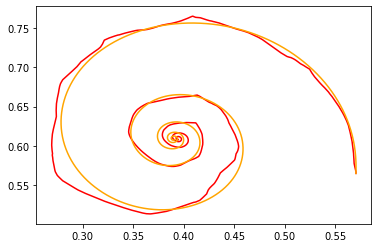

In [21]:
plt.plot(latent_encoded_computed[:,0].cpu().detach().numpy(), 
                latent_encoded_computed[:,1].cpu().detach().numpy(), 'red', label="Computed")

plt.plot(predicted_output[:,-1,0].cpu().detach().numpy(), 
                predicted_output[:,-1,1].cpu().detach().numpy(), 'orange', label="Predicted")

In [22]:
from skimage.color import gray2rgb
# switch to rgb images 
reconstructed_trajectory_np = reconstructed_trajectory.detach().numpy()
reconstructed_trajectory_np = np.array([gray2rgb(img[0]) for img in reconstructed_trajectory_np])
# normalize the images
reconstructed_trajectory_np = 350*(reconstructed_trajectory_np - reconstructed_trajectory_np.min())/(reconstructed_trajectory_np.max() - reconstructed_trajectory_np.min())
print(reconstructed_trajectory_np.shape)

inputs_images = inputs.numpy()
inputs_images = np.array([gray2rgb(img[0]) for img in inputs_images])
inputs_images = 350*(inputs_images - inputs_images.min())/(inputs_images.max() - inputs_images.min())
print(inputs_images.shape)

(10000, 28, 28, 3)
(10000, 28, 28, 3)


In [23]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Computed", "Predicted"))
fig = go.FigureWidget(fig)
fig.add_image(z=reconstructed_trajectory_np[300], row=1, col=1)
fig.add_image(z=inputs_images[300], row=1, col=2)
# fig.add_image(z=inputs.numpy()[300]*350, row=2, col=1)
# fig = go.Figure(go.Heatmap(z=reconstructed_trajectory_np[0], colorscale='gray'))
fig

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'cf740c6f-2f78-4b81-9ab8-b3102999deae',
   …

In [24]:


def interactive_image_plot(inputs_images, reconstructed_images, time_steps, dt):
    fig = make_subplots(rows=1, cols=3, subplot_titles=("Input image", "Predicted image"))
    fig = go.FigureWidget(fig)
    # add a black background to the figure
    fig.add_image(z=inputs_images[0], row=1, col=1, name='true image')
    fig.add_image(z=reconstructed_images[0], row=1, col=2, name='predicted image')

    N_max = len(inputs_images)-1

    @interact(t=(time_steps.min(),time_steps.max(),dt))
    def update_plot(t):
        with fig.batch_update():
            # change the current point of 
            fig.data[0].z = inputs_images[min(int(t/dt), N_max)]
            fig.data[1].z = reconstructed_images[min(int(t/dt), N_max)]

    return fig

fig = interactive_image_plot(inputs_images, reconstructed_trajectory_np, times.numpy(), 0.001)
# print(fig)
fig

interactive(children=(FloatSlider(value=5.0, description='t', max=10.0, step=0.001), Output()), _dom_classes=(…

FigureWidget({
    'data': [{'name': 'true image',
              'type': 'image',
              'uid': '367617…

# Close look at the begining of the trajectory

In [25]:
def interactive_part_trajectory_image_plot(inputs_images, reconstructed_images, time_steps, dt):
    fig = make_subplots(rows=1, cols=3, subplot_titles=("Input image", "Predicted image"))
    fig = go.FigureWidget(fig)
    # add a black background to the figure
    fig.add_image(z=inputs_images[0], row=1, col=1, name='true image')
    fig.add_image(z=reconstructed_images[0], row=1, col=2, name='predicted image')

    N_max_input = len(inputs_images)-1
    N_max_predicted = len(reconstructed_images)-1
    N_max = max(N_max_input, N_max_predicted)

    frac_input = N_max/N_max_predicted
    frac_predicted = N_max/N_max_input

    @interact(t=(time_steps.min(),time_steps.max(),dt))
    def update_plot(t):
        with fig.batch_update():
            # change the current point of 
            print(t/dt)
            print(int(frac_input*t/dt))
            print(int(frac_predicted*t/dt))
            fig.data[0].z = inputs_images[min(int(frac_input*t/dt), N_max_input)]
            fig.data[1].z = reconstructed_images[min(int(frac_predicted*t/dt), N_max_predicted)]

    return fig

# fig = interactive_image_plot(inputs_images, reconstructed_trajectory_np, times.numpy(), 0.001)
# # print(fig)
# fig

In [26]:
final_ite = 3000
dt = 0.001
final_time = final_ite*dt
total_steps = 30000
times = torch.linspace(0., final_time, total_steps, dtype=torch.float64).float()

predicted_output = ode(latent_encoded[0].unsqueeze(0), times)
print(predicted_output.shape)
reconstructed_trajectory = ae.decoder(ae.decoder_linear(predicted_output).reshape(-1, 128, 3, 3))
print(reconstructed_trajectory.shape)

torch.Size([30000, 1, 2])
torch.Size([30000, 1, 28, 28])


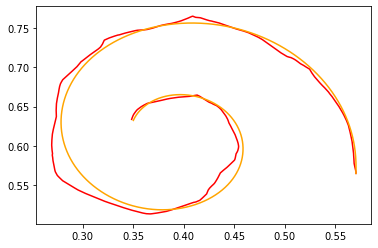

In [27]:
plt.plot(latent_encoded_computed[:final_ite,0].cpu().detach().numpy(), 
                latent_encoded_computed[:final_ite,1].cpu().detach().numpy(), 'red', label="Computed")

plt.plot(predicted_output[:,-1,0].cpu().detach().numpy(), 
                predicted_output[:,-1,1].cpu().detach().numpy(), 'orange', label="Predicted")

In [28]:
from skimage.color import gray2rgb
# switch to rgb images 
reconstructed_trajectory_np = reconstructed_trajectory.detach().numpy()
reconstructed_trajectory_np = np.array([gray2rgb(img[0]) for img in reconstructed_trajectory_np])
# normalize the images
reconstructed_trajectory_np = 350*(reconstructed_trajectory_np - reconstructed_trajectory_np.min())/(reconstructed_trajectory_np.max() - reconstructed_trajectory_np.min())
print(reconstructed_trajectory_np.shape)

inputs_images = inputs.numpy()[:final_ite]
inputs_images = np.array([gray2rgb(img[0]) for img in inputs_images])
inputs_images = 350*(inputs_images - inputs_images.min())/(inputs_images.max() - inputs_images.min())
print(inputs_images.shape)

(30000, 28, 28, 3)
(3000, 28, 28, 3)


In [29]:
fig = interactive_part_trajectory_image_plot(inputs_images, reconstructed_trajectory_np, times.numpy(), dt)
fig

interactive(children=(FloatSlider(value=1.0, description='t', max=3.0, step=0.001), Output()), _dom_classes=('…

FigureWidget({
    'data': [{'name': 'true image',
              'type': 'image',
              'uid': '82eb76…